### Introduction - What we'll cover
#### In this tutorial, we would build and test a model the performs image recognition

1. Setup Pytorch and Import the neccessary modules
2. Download the training dataset
3. Download the test dataset
4. Preview the the images
5. Create the data loaders
6. Examine he shape of the data
7. Declare your device
8. Create the NeuralNetwork model
9. Train the model
10. Ensure the loss reduces with training
11. Test the Model with test dataset
12. Examine the Accuracy/Loss
13. Save your model
14. Load your model
15. Use the model to make prediction

### Part 1 - Install Pytorch and Import neccessary modules

In [49]:
conda install pytorch torchvision -c pytorch

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.7.1



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

### Part 2 - Downlaod the Training Dataset

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [6]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Part 3 - Download the Test Dataset

In [7]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [8]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Part 4 - View the Images

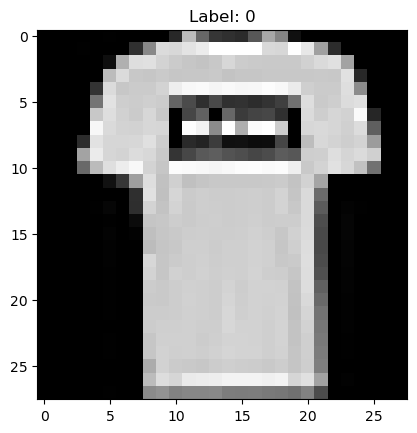

In [11]:
import matplotlib.pyplot as plt
image, label = training_data[1]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### Part 5 - Create the Data Loaders

In [12]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

### Part 6 - Examine the Shape of the Data

In [19]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]), torch.int64


### Part 7 - Declare Your Device

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


### Part 8 - Create Your Model 
- create a class that extends the nn.Module class
- define the layers of the network in the init method
- specify how data would pass through the network in the forward function

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # create the input layer
        self.flatten = nn.Flatten()
        
        # create the 2 hidden layers
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Part 9, 10 - Train the Model

In [38]:
size = len(train_dataloader.dataset)
model.train()

learning_rate = 0.01
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for batch, (X, y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)
    
    # forward pass: make predict and compute loss
    y_predicted = model(X)
    loss = loss_function(y_predicted, y)
    
    # backward pass: 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if batch % 100 == 0:
        loss = loss.item()
        current = (batch + 1) * len(X)
        
        print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Loss: 0.556356  [   64/60000]
Loss: 0.651494  [ 6464/60000]
Loss: 0.439277  [12864/60000]
Loss: 0.669322  [19264/60000]
Loss: 0.581347  [25664/60000]
Loss: 0.556760  [32064/60000]
Loss: 0.595068  [38464/60000]
Loss: 0.638834  [44864/60000]
Loss: 0.674050  [51264/60000]
Loss: 0.552437  [57664/60000]


### 11, 12. Test the Model

In [39]:
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)

model.eval()

test_loss = 0
correct = 0

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        
        y_predicted = model(X)
        test_loss = test_loss + loss_function(y_predicted, y).item()
        correct = correct + (y_predicted.argmax(1) == y).type(torch.float).sum().item()
        
test_loss = test_loss/num_batches
correct = correct/size

print("Model Accuracy and Loss \n")
print(f"Accuacy: {(correct*100) :>0.1f}%, Avg. Loss: {test_loss:>8f} \n")

Model Accuracy and Loss 

Accuacy: 79.7%, Avg. Loss: 0.572809 



### Part 13 - Save Your Model

In [40]:
torch.save(model.state_dict(), "model.pth")
print("Model has beeen saved to model.pth")

Model has beeen saved to model.pth


### Part 14 - Loading Your Model

In [43]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [44]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### Part 15 - Use the Model to Make Prediction

In [48]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sanda",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

model.eval()

x = test_data[0][0]
y = test_data[0][1]

with torch.no_grad():
    x = x.to(device)
    prediction = model(x)
    
    predicted = classes[prediction[0].argmax(0)]
    actual = classes[y]
    
    print(f"Predicted:  {predicted}, Actual: {actual}")

Predicted:  Ankle boot, Actual: Ankle boot


## Part 16 - Next Steps

1 Tensor Basics \
2 Autograd \
3 Backpropagation \
4 Gradient Descent \
5 Training Pipeline \
6 Linear Regression \
7 Logistic Regression \
8 Dataset and Dataloader \
9 Dataset Transforms \
10 Softmax and Crossentropy \
11 Activation Functions \
12 Feed Forward Net \
13 CNN \
14 Transfer Learning \
15 Tensorboard \
16 Image Filter \
17 Next Steps \